<a href="https://colab.research.google.com/github/emanbuc/ultrasonic-vision/blob/main/notebooks/multiclass_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training data

Creo dell nuove colonne calcolate nel dataset per avere delle feauture meno dipendenti dalla posizione dell'oggetto all'interno dell'area di misura

     HCSR04_001  ...  differentialDistanceFromRoof57
0         55.59  ...                          -44.65
1         56.40  ...                          -58.41
2         56.32  ...                          -64.95
3         55.08  ...                          -27.32
4         55.11  ...                          -59.80
..          ...  ...                             ...
302       53.43  ...                          -58.16
303       53.40  ...                          -56.18
304       53.83  ...                          -60.10
305       53.40  ...                          -57.92
306       53.41  ...                          -57.50

[307 rows x 13 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


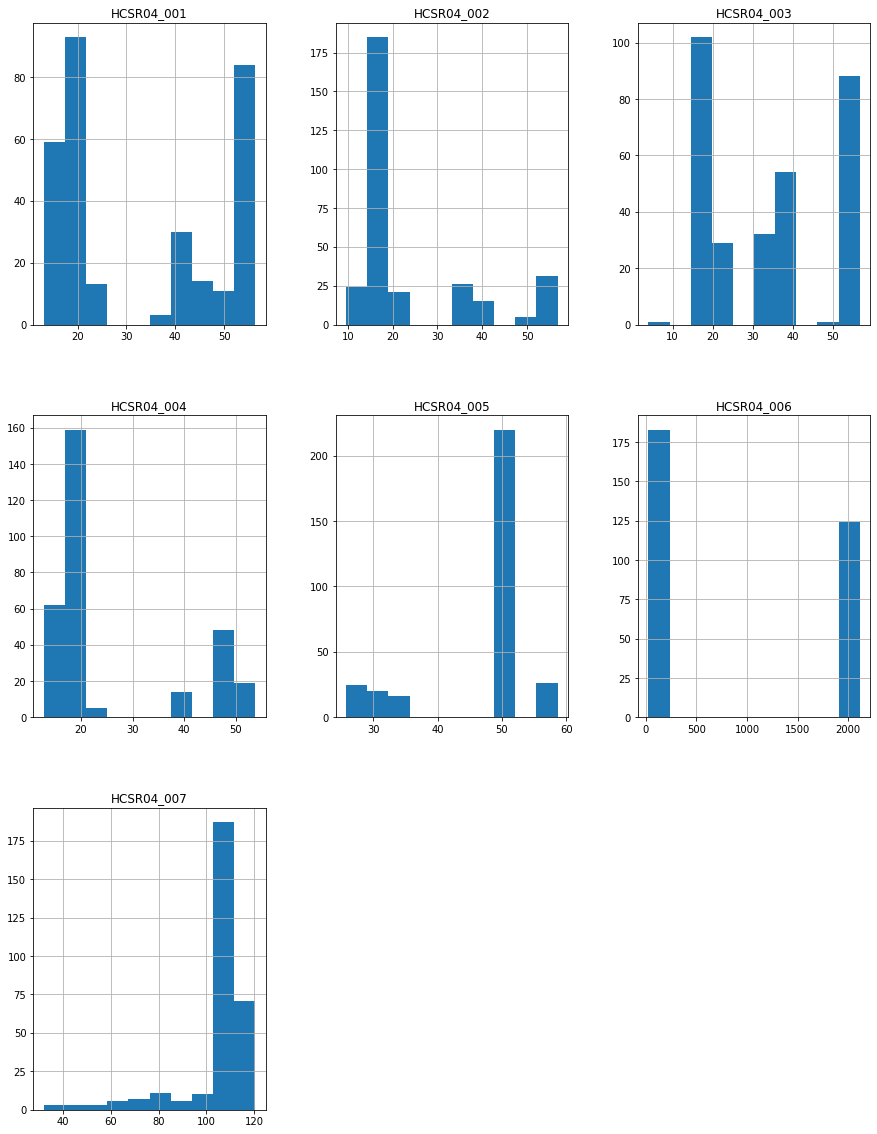

In [5]:

url = "https://raw.githubusercontent.com/emanbuc/ultrasonic-vision/main/dataset/20210102_alldata_outlier_removed.csv"
names = ['HCSR04_001', 'HCSR04_002', 'HCSR04_003', 'HCSR04_004', 'HCSR04_005', 'HCSR04_006', 'HCSR04_007',"ObjectClass"]
data = pandas.read_csv(url, usecols=names)
# somma delle distanze dai sensori bassi montati sui pannelli verticali
data['distanceSumHi'] = data.HCSR04_001 + data.HCSR04_002

# somma delle distanze dai sensori alti  montati sui pannelli orizzontali
data['distanceSumLow'] = data.HCSR04_003 + data.HCSR04_004

# differenza distanza da sensori tetto
data['differentialDistanceFromRoof65'] = data.HCSR04_006 - data.HCSR04_005
data['differentialDistanceFromRoof67'] = data.HCSR04_006 - data.HCSR04_007
data['differentialDistanceFromRoof57'] = data.HCSR04_005 - data.HCSR04_007

print(data)
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.iloc[:,0:7].hist(ax = ax)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


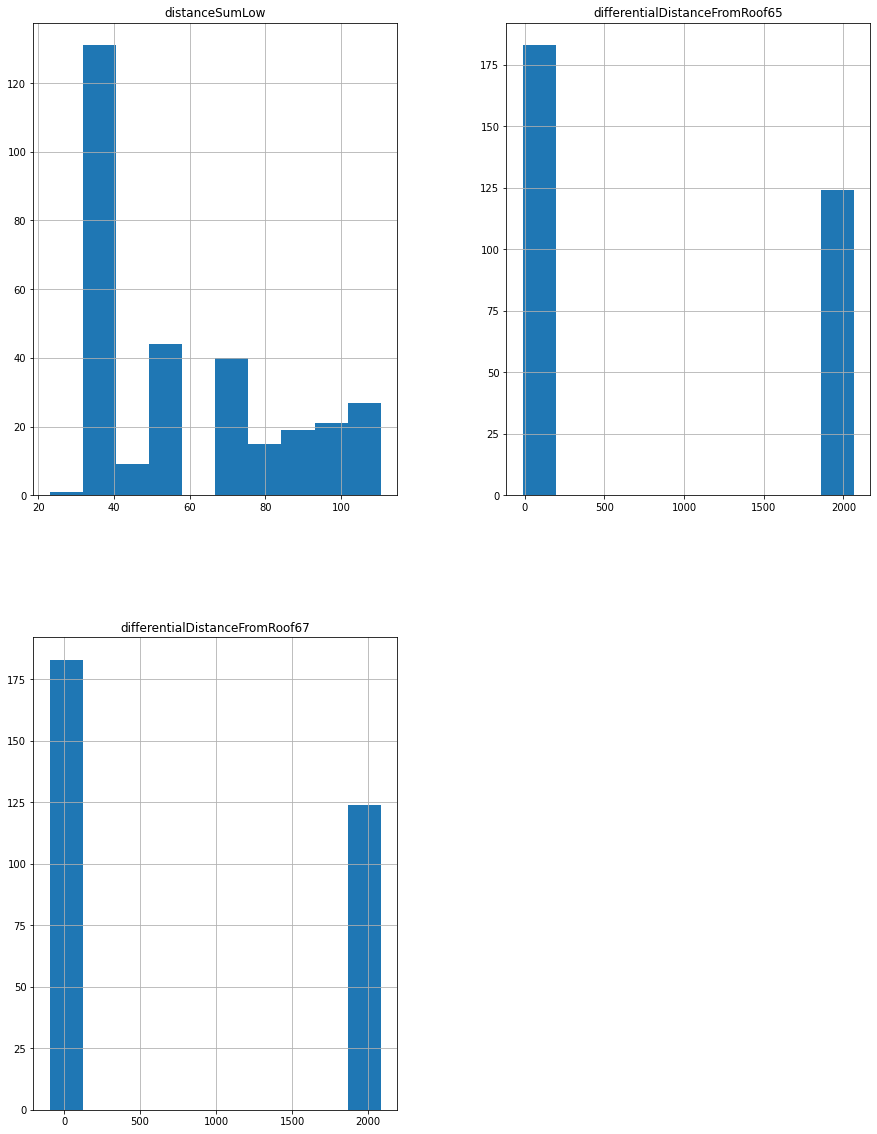

In [6]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.iloc[:,9:12].hist(ax = ax)
plt.show()

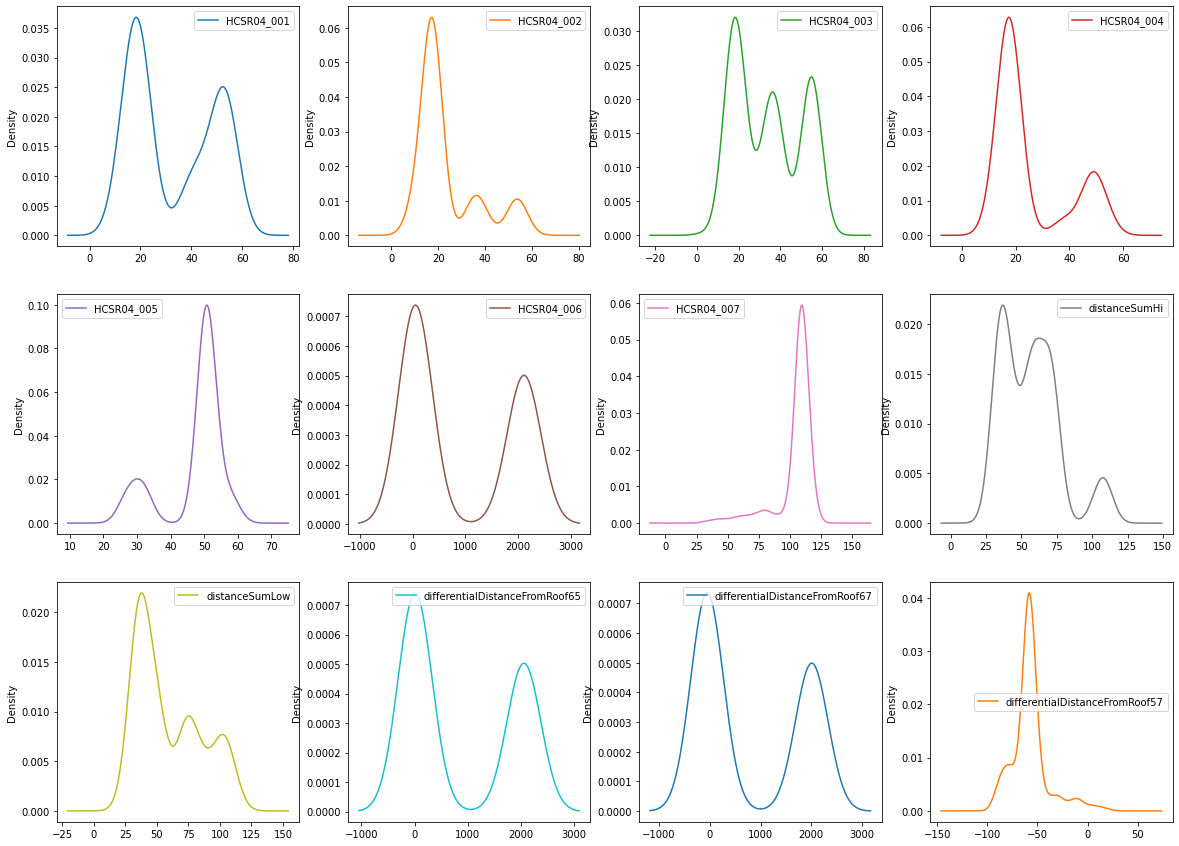

In [8]:
data.plot(kind='density', subplots=True, layout=(3,4), sharex=False, figsize=(20,15))
plt.show()

## Analisi dati HCSR04-007


BALL_CENTER
BEAN_CAN
BEER_BOTTLE
EMPTY_SEVEN
GLASS
RECTANGULAR_BOX
RECTANGULAR_BOX_SIDE
SOAP_BOTTLE_FRONT
SOAP_BOTTLE_SIDE
SQUARE_MILK_45
SQUARE_MILK_90
WALL_BALL


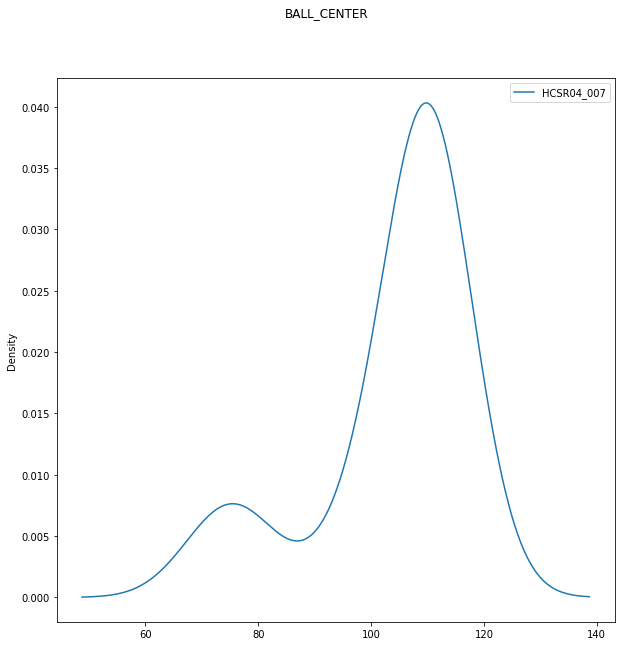

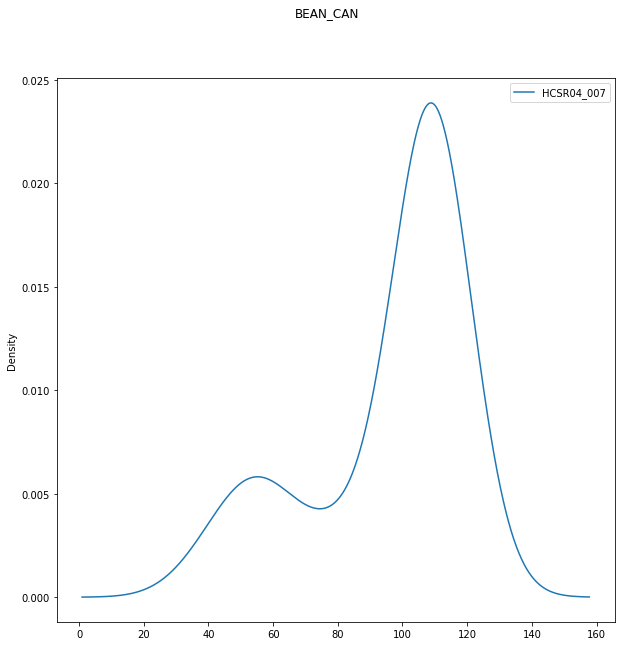

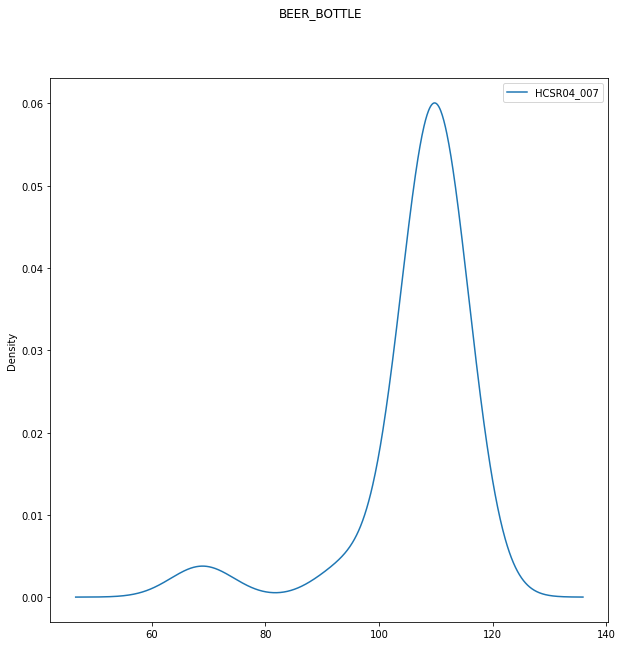

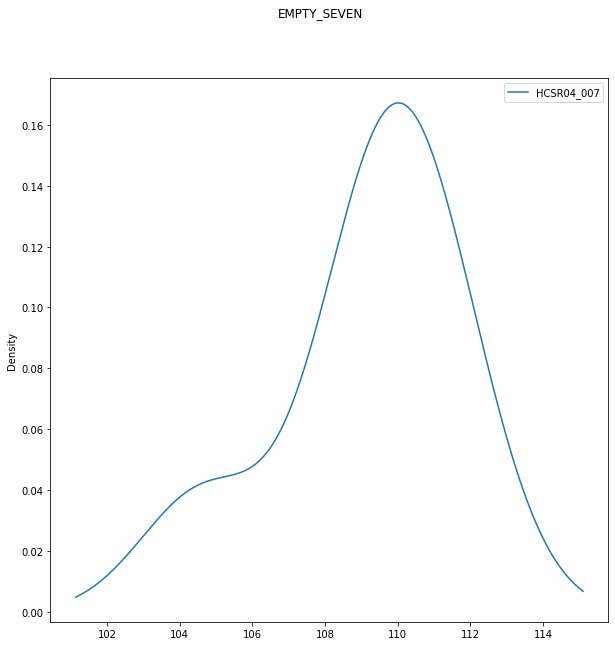

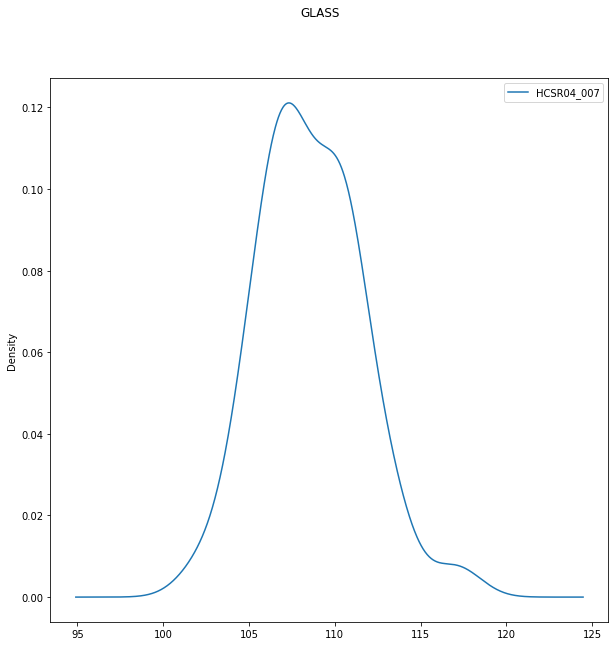

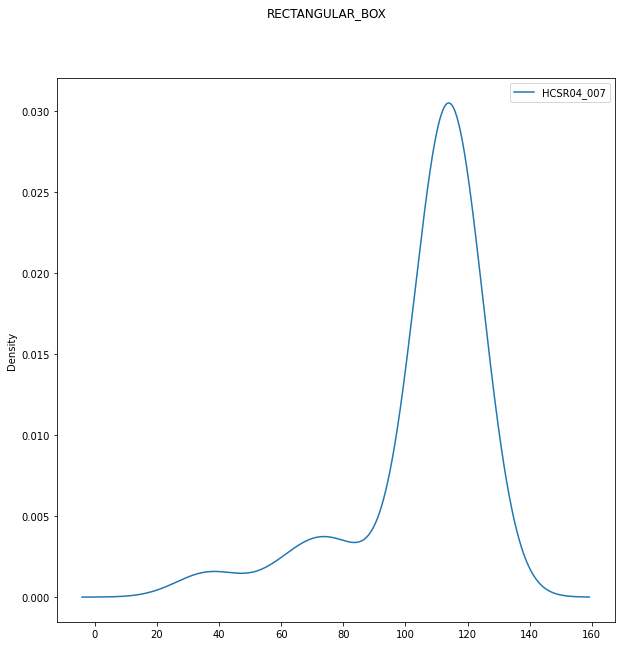

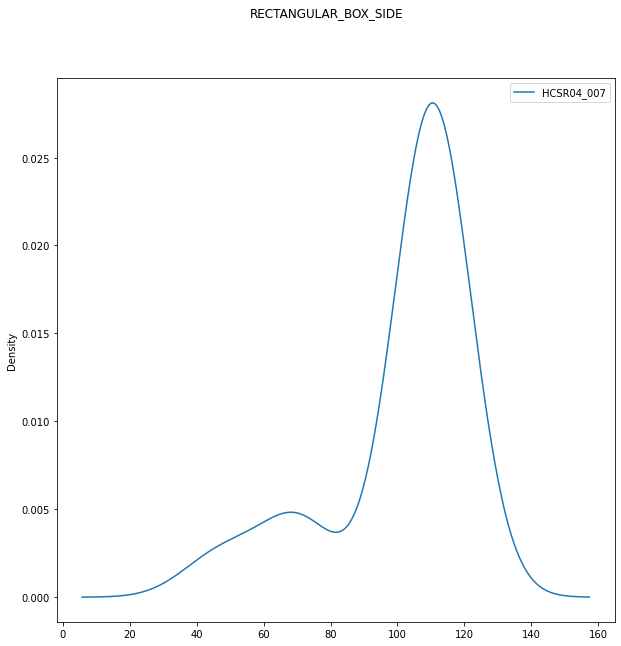

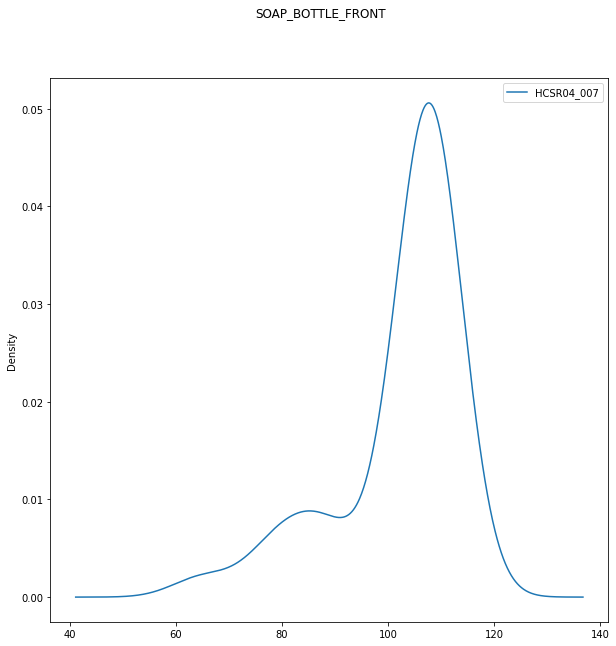

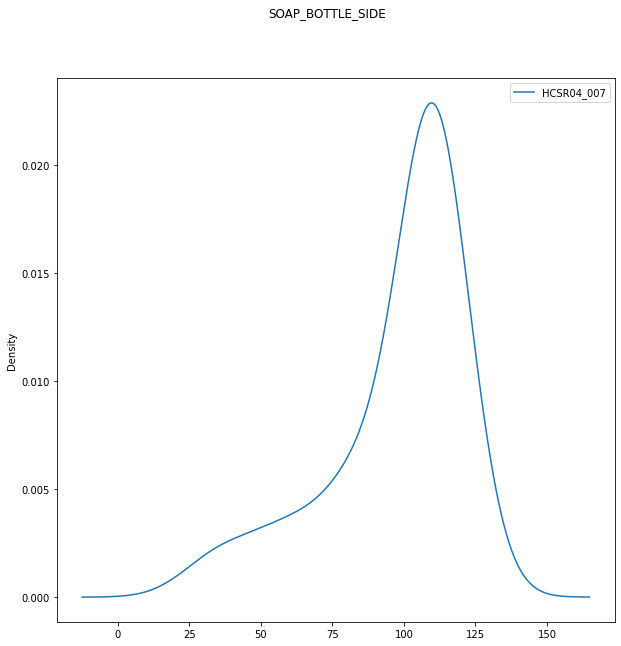

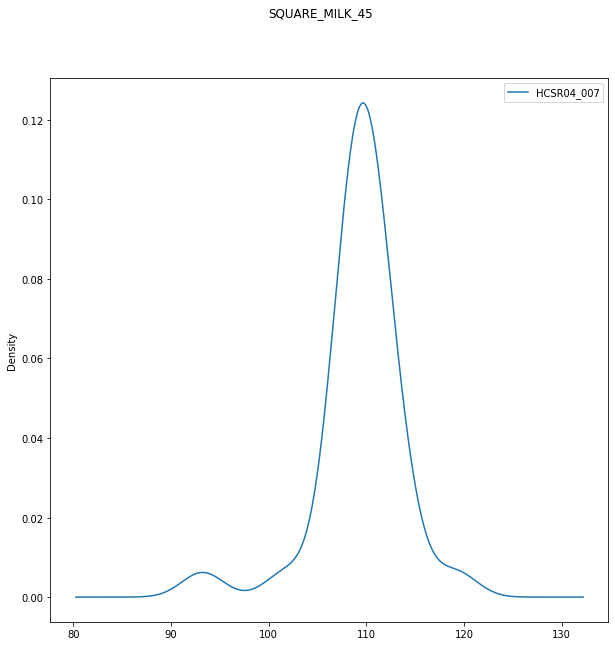

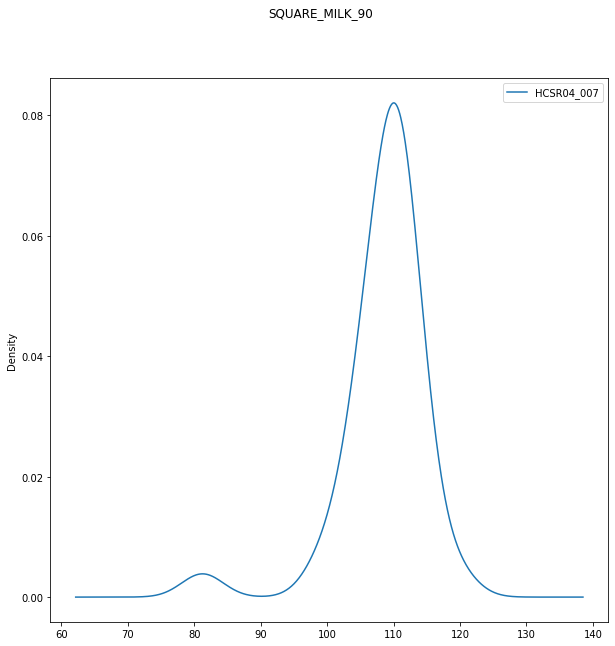

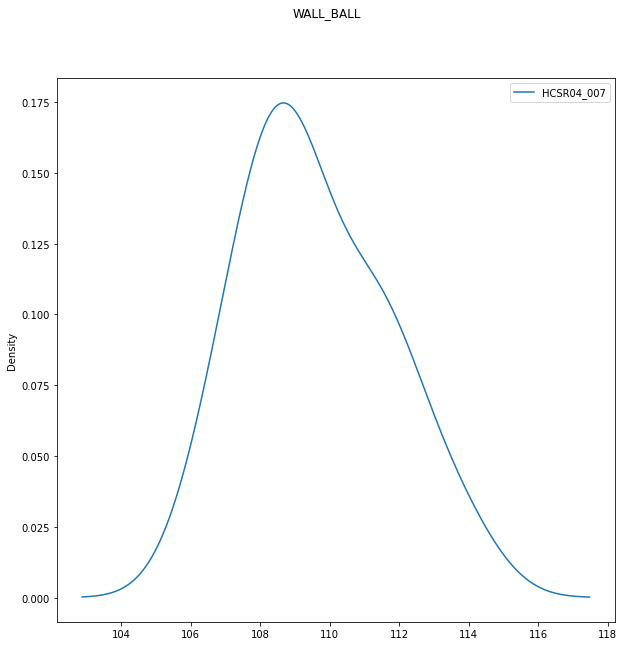

In [17]:
data_HCSR04_007 = data.loc[:,['HCSR04_007','ObjectClass']]

for name, group in data_HCSR04_007.groupby(['ObjectClass']):
    # print the name of the regiment
    print(name)
    group.plot(kind='density', subplots=True, layout=(1,1), sharex=False, figsize=(10,10), title=name)

La distibuzione delle stime fornite da HCSR04_007 nei vari esperimenti è diversa. I dati di HCSR04_007, anche se le stime sono fortemente errate potrebbero quindi contenere informazione utile alla classificazione degli oggetti

## Analisi dati HCSR-04_006

    HCSR04_006  ObjectClass
0        57.48  BALL_CENTER
1        57.42  BALL_CENTER
2        58.30  BALL_CENTER
3        58.28  BALL_CENTER
4        57.86  BALL_CENTER
5        57.44  BALL_CENTER
6        58.77  BALL_CENTER
7        57.43  BALL_CENTER
8        57.84  BALL_CENTER
9        54.02  BALL_CENTER
10       54.45  BALL_CENTER
11       54.91  BALL_CENTER
12       54.01  BALL_CENTER
13       54.45  BALL_CENTER
14       54.68  BALL_CENTER
15       54.43  BALL_CENTER
16       54.89  BALL_CENTER
17       54.04  BALL_CENTER
18       54.28  BALL_CENTER
19       54.86  BALL_CENTER
    HCSR04_006 ObjectClass
20     2115.51    BEAN_CAN
21     2114.53    BEAN_CAN
22     2114.58    BEAN_CAN
23     2114.95    BEAN_CAN
24     2114.89    BEAN_CAN
25     2114.74    BEAN_CAN
26     2115.73    BEAN_CAN
27     2115.19    BEAN_CAN
28     2115.16    BEAN_CAN
29     2115.65    BEAN_CAN
30     2115.82    BEAN_CAN
31     2115.00    BEAN_CAN
32     2114.92    BEAN_CAN
33     2114.63    BEAN_CAN
34     

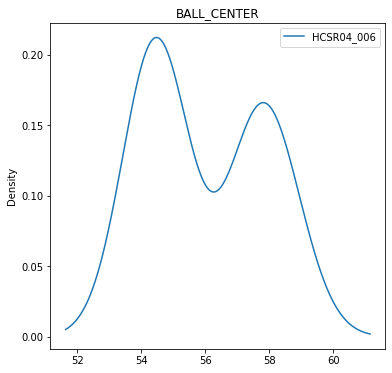

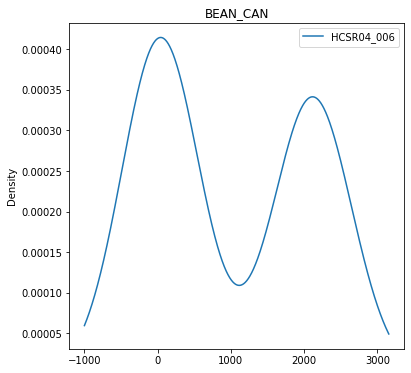

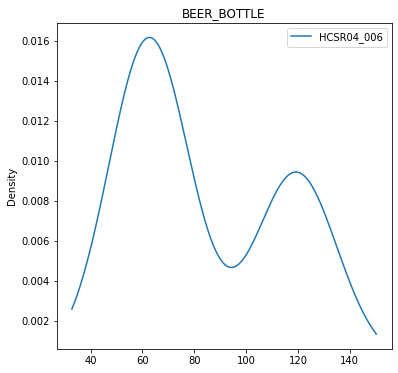

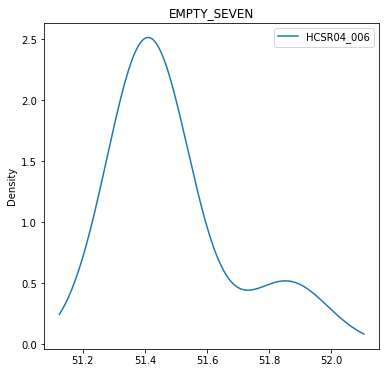

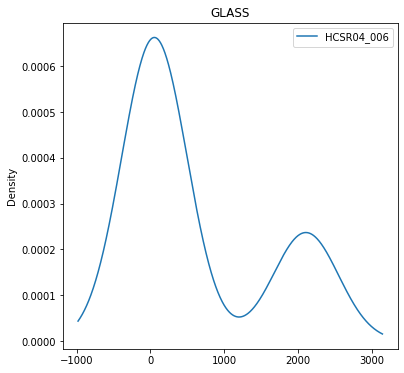

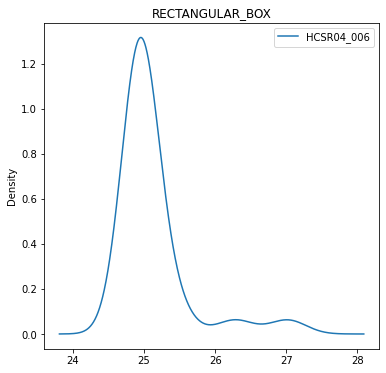

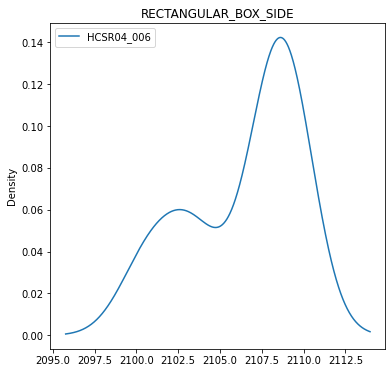

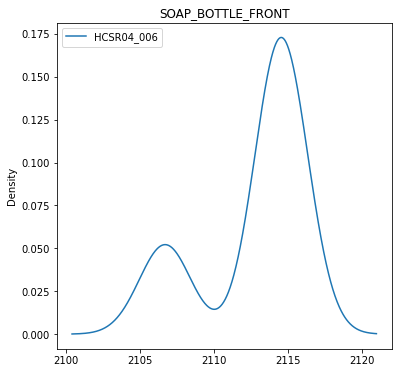

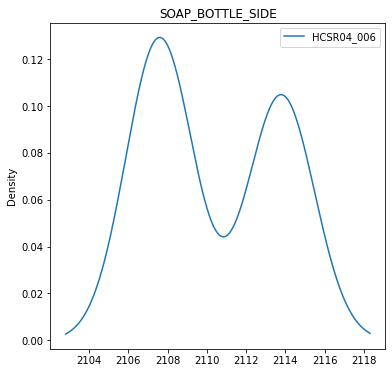

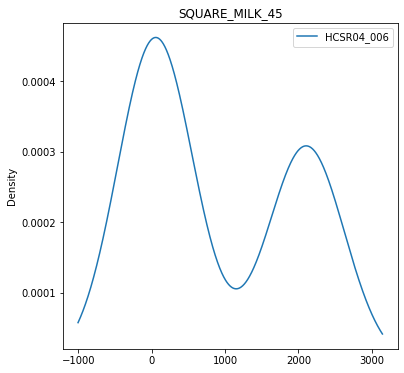

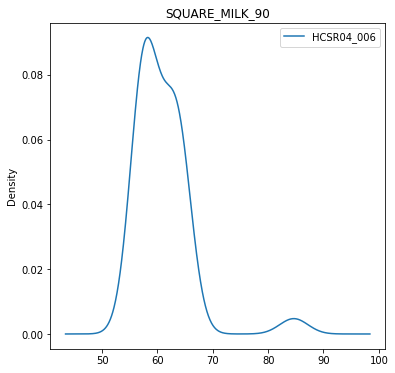

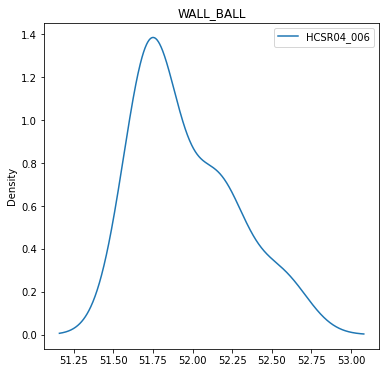

In [22]:
data_HCSR04_006 = data.loc[:,['HCSR04_006','ObjectClass']]

for name, group in data_HCSR04_006.groupby(['ObjectClass']):
    # print the name of the regiment
    group.plot(kind='density', layout=(1,1), sharex=False, figsize=(6,6), title=name)
    print(group)

Un numero significativo di stime fornite da HCSR04_006 sono intorno al valore 2000 cm. Probabilmente di tratta di echi arrivati dopo diverse riflessioni.

Sui dati del sensore HCSR-04_006 sono ancora presenti molte distanze palesemente errate con valori intorno a 200 cm. Non è chiaro che questi dati possano essere utile per l'addestramento del modello. Per verificare sperimentalmente quale sia il migliore dataset di addestramento sono stati addestrati diversi modelli le cui prestazioni saranno poi verificate sul campo:

- dataset originale 
- senza dati HCSR-04_007
- senza dati HCSR-04_007 e senza letture anomale di HCSR

In [ ]:
x_train = data[['distanceSumHi','distanceSumLow','differentialDistanceFromRoof65','differentialDistanceFromRoof67','differentialDistanceFromRoof57']]
y_train = data[['ObjectClass']]

In [ ]:
x_train

,distanceSumHi,distanceSumLow,differentialDistanceFromRoof65,differentialDistanceFromRoof67,differentialDistanceFromRoof57
0,107.44,109.71,1.33,28.57,27.24
1,107.44,109.68,0.90,-66.02,-66.92
2,107.78,110.13,1.80,-57.91,-59.71
3,107.82,109.73,0.95,-53.19,-54.14
4,107.89,110.02,1.29,-53.84,-55.13
...,...,...,...,...,...
264,59.60,87.68,26.30,-62.26,-88.56
265,60.11,88.52,27.07,-54.13,-81.20
266,60.04,87.93,26.71,-53.88,-80.59
267,60.12,88.20,27.01,-53.63,-80.64


In [ ]:
y_train

,ObjectClass
0,EMPTY_SEVEN
1,EMPTY_SEVEN
2,EMPTY_SEVEN
3,EMPTY_SEVEN
4,EMPTY_SEVEN
...,...
264,SQUARE_MILK_90
265,SQUARE_MILK_90
266,SQUARE_MILK_90
267,SQUARE_MILK_90


In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train, np.ravel(y_train))
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
x_test= [59,87,26,-53,-79]

In [ ]:
clf.predict([x_test])

array(['SQUARE_MILK_90'], dtype=object)

## Salvataggio Modello addestrato

In [ ]:
import pickle
from google.colab import files
filename='svm_classificator_model_pickle_outline_removed.pkl'
pickle.dump(clf, open(filename, 'wb'))
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Caricamento modello da file

In [ ]:
load_lr_model =pickle.load(open(filename, 'rb'))
load_lr_model.predict([x_test])

array(['SQUARE_MILK_90'], dtype=object)